In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import KNNImputer
from sklearn.feature_selection import SelectKBest, f_regression, chi2, SelectPercentile, mutual_info_regression
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.neighbors import LocalOutlierFactor
import math
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.gaussian_process.kernels import RationalQuadratic
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import r2_score

In [2]:
SEED = 4426008 #np.random.randint(2**32)
np.random.seed(SEED)

In [3]:
TRAIN_RATIO = 0.8

def train_len(data = None):
    if data is None:
        data = x_train
    return math.floor(TRAIN_RATIO*len(data))

def validation_len(data = None):
    if data is None:
        data = x_train
    return len(data) - train_len(data)

def train(data = None):
    if data is None:
        data = x_train
    if isinstance(data, np.ndarray):
        return data[:train_len(data)].copy()
    return data.iloc[:train_len(data)].copy()

def validation(data = None):
    if data is None:
        data = x_train
    if isinstance(data, np.ndarray):
        return data[-validation_len(data):].copy()
    return data.iloc[-validation_len(data):].copy()

def full_X(x_tr = None, x_ts = None):
    if x_tr is None:
        x_tr = x_train
    if x_ts is None:
        x_ts = x_test
    return pd.concat([x_tr, x_ts], join = "inner")

In [4]:
just_scoring = False
if just_scoring:
  folder = "just_scoring/"
else:
  folder = "testing/"
folder = folder + ""
raw = folder + "outlier_detected/"
preprocessed = folder + "feature_reduced/"

In [5]:
x_train = pd.read_csv(raw + 'X_train_preprocessed.csv',index_col=['id'])
x_test = pd.read_csv(raw + 'X_test_preprocessed.csv',index_col=['id'])
y_train = pd.read_csv(raw + 'y_train_preprocessed.csv',index_col=['id'])
y_test = pd.read_csv(raw + 'y_test_preprocessed.csv',index_col=['id'])

In [6]:
# x_train_old = x_train.copy()
# s = RobustScaler()
# s.fit(full_X())
# x_train[[col for col in x_train.columns]] = s.transform(x_train)
# x_test[[col for col in x_train.columns]] = s.transform(x_test)
# x_train
# x_train_old

In [7]:
s = RobustScaler()
s.fit(full_X())
x_train[[col for col in x_train.columns]] = s.transform(x_train)
x_test[[col for col in x_train.columns]] = s.transform(x_test)

In [8]:
%%time
flag = True
x_train_old = x_train.copy()
iter = 0
while flag or x_train_old.shape[1]!=x_train.shape[1]:
    x_train = x_train.sample(frac=1)
    y_train = y_train.loc[x_train.index]
    
#     if x_train_old.shape[1]==x_train.shape[1] and iter>0:
#         flag = False
#     else:
#         flag = True

    x_train_old = x_train.copy()
    flag = False
    
    #random_state=np.random.randint(0, 2**31), 
    
    etr = ExtraTreesRegressor(n_estimators = 1000, n_jobs=-1)
    etr.fit(train(x_train), np.ravel(train(y_train)))
    importances = permutation_importance(etr, validation(x_train), validation(y_train),
                               n_repeats=12, n_jobs=-1)
    importances = importances.importances_mean
    importances_etr = importances>0
    col_etr = np.ravel(np.argwhere(importances_etr))
    
    
    x_train = x_train.sample(frac=1)
    y_train = y_train.loc[x_train.index]
    
    etr = ExtraTreesRegressor(n_estimators = 1000, n_jobs=-1)
    etr.fit(train(x_train), np.ravel(train(y_train)))
    importances = permutation_importance(etr, validation(x_train), validation(y_train),
                               n_repeats=12, n_jobs=-1)
    importances = importances.importances_mean
    importances_etr = importances>0
    col_etr2 = np.ravel(np.argwhere(importances_etr))
       
    x_train = x_train.sample(frac=1)
    y_train = y_train.loc[x_train.index]
    
    kernel = RationalQuadratic()
    etr = GaussianProcessRegressor(kernel = kernel, normalize_y = True)
    etr.fit(train(x_train), np.ravel(train(y_train)))
    importances = permutation_importance(etr, validation(x_train), validation(y_train),
                               n_repeats=36, n_jobs=-1)
    importances = importances.importances_mean
    importances_krr = importances>0
    col_krr = np.ravel(np.argwhere(importances_krr))
    
    
    selector = SelectPercentile(mutual_info_regression, percentile=10)
    selector.fit(np.array(x_train), np.array(y_train).squeeze())
    cols_mutual_info_regression = selector.get_support(indices=True)
    
    
    selector = SelectPercentile(f_regression, percentile=10)
    selector.fit(np.array(x_train), np.array(y_train).squeeze())
    cols_f_regression = selector.get_support(indices=True)
    
    set_all_columns = (set(col_etr) | set(col_etr2) | set(cols_mutual_info_regression) | set(cols_f_regression) | set(col_krr))
    list_all_columns = list(set_all_columns)
    x_train = x_train.iloc[:, list_all_columns]
    
    print(x_train.shape)
    iter += 1
    


(1087, 741)
(1087, 641)
(1087, 583)
(1087, 534)
(1087, 514)
(1087, 473)
(1087, 442)
(1087, 391)
(1087, 376)
(1087, 367)
(1087, 324)
(1087, 311)
(1087, 255)
(1087, 249)
(1087, 226)
(1087, 213)
(1087, 204)
(1087, 200)
(1087, 170)
(1087, 156)
(1087, 152)
(1087, 148)
(1087, 146)
(1087, 143)
(1087, 142)
(1087, 136)
(1087, 136)
CPU times: total: 3h 48min 2s
Wall time: 4h 8min 48s


In [9]:
x_test = x_test[[col for col in x_train.columns]]

In [10]:
x_train.to_csv(preprocessed + 'X_train_preprocessed.csv',index_label="id")
x_test.to_csv(preprocessed + 'X_test_preprocessed.csv',index_label="id")
y_train.to_csv(preprocessed + 'y_train_preprocessed.csv',index_label="id")
y_test.to_csv(preprocessed + 'y_test_preprocessed.csv',index_label="id")

In [11]:
stop here

SyntaxError: invalid syntax (4067800170.py, line 1)

In [18]:
x_train

,x2,x6,x8,x17,x23,x42,x51,x60,x65,x69,...,x735,x742,x754,x774,x776,x782,x783,x795,x827,x828
id,,,,,,,,,,,,,,,,,,,,,
124.0,-0.640153,1.413600,-0.458523,0.727484,-0.407202,-0.360423,-0.801644,-0.773290,1.065081,-0.537347,...,0.517242,-1.223790,0.536230,-0.843395,-0.795930,0.686460,-0.424909,0.531791,-1.674551,-1.009797
178.0,0.554127,1.363075,0.026355,0.025575,0.447635,1.141528,-0.852888,0.155695,-1.284154,0.698667,...,-0.351589,0.074811,-0.000538,0.114315,0.863238,-0.008944,1.087813,-0.242313,0.626327,-0.701236
1088.0,0.155643,-0.868452,-0.036660,-0.269913,0.516866,-0.804754,-0.057434,1.065110,-0.492981,0.536688,...,-0.326767,0.218743,-0.794325,-0.341438,0.304049,-0.744808,-0.560412,-0.001115,0.368863,-0.051142
15.0,0.201366,0.041130,-0.739757,-0.103427,-0.220532,-0.838797,-0.204203,-0.842002,0.284307,0.340760,...,0.002186,0.250288,0.731188,-0.319969,-0.854192,-0.028950,1.085784,-0.019192,0.740875,-0.021295
1058.0,-0.931668,0.484016,-0.919151,-0.178743,-1.577617,-0.896364,-0.576772,0.318287,-0.851589,-0.827132,...,0.496186,-1.105829,0.440123,-0.692422,0.333676,-0.429249,-1.323298,0.477411,-0.782385,0.154279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354.0,-0.476903,2.015711,-1.029994,-0.579864,0.577311,0.955033,0.855709,0.279687,-0.131841,-0.065176,...,0.980969,-0.487768,-0.714850,0.155130,0.773954,0.195495,0.602806,-0.253744,0.222565,1.011351
1103.0,2.508357,-0.063506,-0.071101,-0.061963,1.895425,-0.216826,-0.162210,-0.056163,0.083830,3.511215,...,-0.015202,5.345413,-0.045588,2.421990,-0.052652,-0.060759,1.979639,0.017578,2.340883,0.079844
756.0,-0.021369,0.062090,0.860957,-1.380272,-0.187886,-0.584701,-1.404156,0.548543,0.012168,0.213590,...,0.777336,-0.291067,0.900660,-1.188400,-0.536699,0.619853,0.238338,-0.560214,-0.446793,-0.847286


In [ ]:
x_train_old = x_train.copy()
s = RobustScaler()
s.fit(x_train)
x_train[[col for col in x_train.columns]] = s.transform(x_train)
x_test[[col for col in x_train.columns]] = s.transform(x_test)

In [ ]:
#x_train_old = x_train.copy()
x_train = x_train.sample(frac=1)
y_train = y_train.loc[x_train.index]

In [12]:
from sklearn.metrics import r2_score
kernel = RationalQuadratic()
etr = GaussianProcessRegressor(kernel = kernel, random_state=13, normalize_y = True)
etr.fit(train(x_train), np.ravel(train(y_train)))
y_pred_gpr = etr.predict(validation(x_train))
print(r2_score(validation(y_train),y_pred_gpr))
#0.5174025667796436
#0.31217216719480234
#0.318438650058514

0.6133047369720884


In [13]:
from sklearn.metrics import r2_score
kernel = RationalQuadratic()
etr = ExtraTreesRegressor(n_estimators = 1000, random_state=0,  n_jobs=-1)
etr.fit(train(x_train), np.ravel(train(y_train)))
y_pred_gpr = etr.predict(validation(x_train))
print(r2_score(validation(y_train),y_pred_gpr))
#0.4526495353644234
#0.36856761948067485

0.5728214790866666


In [14]:
from sklearn.ensemble import RandomForestRegressor
kernel = RationalQuadratic()
etr = RandomForestRegressor(n_estimators = 1000, n_jobs=-1)
etr.fit(train(x_train), np.ravel(train(y_train)))
y_pred_gpr = etr.predict(validation(x_train))
print(r2_score(validation(y_train),y_pred_gpr))
#0.4133329372644725

0.56071711387776


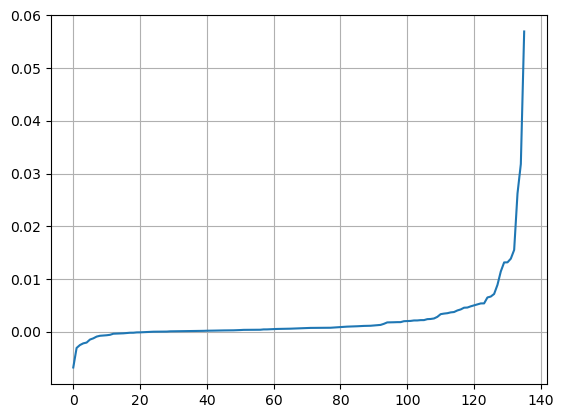

(1087, 136)
(24,)
CPU times: total: 1min 21s
Wall time: 1min 9s


In [15]:
%%time

etr = ExtraTreesRegressor(n_estimators = 1000, random_state=np.random.randint(0, 2**31), n_jobs=-1)
etr.fit(train(x_train), np.ravel(train(y_train)))
importances = permutation_importance(etr, validation(x_train), validation(y_train),
                           n_repeats=10,
                           random_state=np.random.randint(0, 2**31), n_jobs=-1)

importances = importances.importances_mean
std = np.std([tree.feature_importances_ for tree in etr.estimators_], axis=0)

plt.plot(np.sort(importances))
plt.grid()
plt.show()
print(x_train.shape)
print(importances[importances < 0].shape)

importances_etr = importances>0
col_etr = np.ravel(np.argwhere(importances_etr))

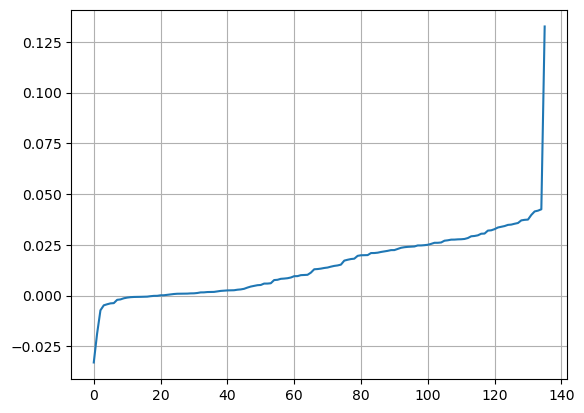

(1087, 136)
(20,)
CPU times: total: 5.58 s
Wall time: 3.32 s


In [16]:
%%time

kernel = RationalQuadratic()
etr = KernelRidge(kernel = kernel)
etr.fit(train(x_train), np.ravel(train(y_train)))
importances = permutation_importance(etr, validation(x_train), validation(y_train),
                           n_repeats=1)

importances = importances.importances_mean
#std = np.std([etr.coef_], axis=0)

plt.plot(np.sort(importances))
plt.grid()
plt.show()
print(x_train.shape)
print(importances[importances < 0].shape)

importances_krr = importances>0
col_krr = np.ravel(np.argwhere(importances_krr))

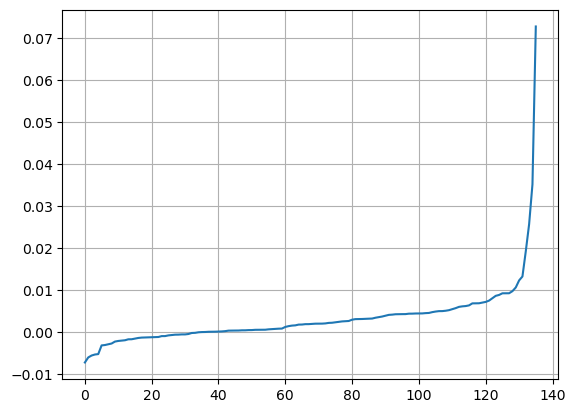

(1087, 136)
(34,)
CPU times: total: 1min 18s
Wall time: 6.57 s


In [17]:
%%time

kernel = RationalQuadratic()
etr = GaussianProcessRegressor(kernel = kernel, normalize_y = True)
etr.fit(train(x_train), np.ravel(train(y_train)))
importances = permutation_importance(etr, validation(x_train), validation(y_train),
                           n_repeats=1)

importances = importances.importances_mean
#std = np.std([etr.coef_], axis=0)

plt.plot(np.sort(importances))
plt.grid()
plt.show()
print(x_train.shape)
print(importances[importances < 0].shape)

importances_krr = importances>0
col_krr = np.ravel(np.argwhere(importances_krr))

In [ ]:
selector = SelectPercentile(mutual_info_regression, percentile=10)
selector.fit(np.array(x_train), np.array(y_train).squeeze())
cols_mutual_info_regression = selector.get_support(indices=True)

In [ ]:
selector = SelectPercentile(f_regression, percentile=10)
selector.fit(np.array(x_train), np.array(y_train).squeeze())
cols_f_regression = selector.get_support(indices=True)

In [ ]:
set_all_columns = (set(col_etr) | set(cols_mutual_info_regression) | set(cols_f_regression) | set(col_krr))
print(len(set_all_columns - set(col_etr)))
list_all_columns = list(set_all_columns)

In [ ]:
x_train = x_train.iloc[:, list_all_columns]
x_train

In [ ]:
#x_train_first = x_train.copy()

In [ ]:
#x_train_second = x_train.copy()

In [ ]:
#x_train_third = x_train.copy()

In [ ]:
#x_train_fourth = x_train.copy()

In [ ]:
#x_train_fifth = x_train.copy()

In [ ]:
#x_train_sixth = x_train.copy()